# CZĘŚĆ 1 - OPTYMALIZACJA

## OPIS ZESTAWU DANYCH
Dane składają się z informacji o przylotach i odlotach wszystkich lotów komercyjnych w USA od października 1987 do kwietnia 2008 – przede wszystkim o ich opóźnieniach. \
Zbiór danych jest bardzo duży (120mln rekordów, 12GB danych) – na potrzeby projektu wykorzystamy jedynie dane z roku 2007 co ograniczy rozmiar przetwarzanych danych.

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import statistics
from sklearn.impute import KNNImputer
import seaborn as sns
import glob
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import isnull, when, count, col, hour, mean, lit, stddev,abs

#### OPIS KLAS
W sumie klas jest 29, opisują one następujące informacje:
* rok
* miesiąc
* dzień miesiąca
* dzień tygodnia
* rzeczywisty czas odlotu
* zaplanowany czas odlotu
* rzeczywisty czas przylotu
* zaplanowany czas przylotu
* kod przewoźnika
* numer lotu
* numer ogonowy samolotu
* całkowity czas lotu w minutach
* rzeczywisty czas lotu
* całkowity czas w powietrzu
* opóźnienie lotu w minutach
* miejsce startu
* miejsce docelowe
* odległość w milach
* dane dotyczące przyjazdu taksówki
* informacje o tym czy lot był anulowany
* powód anulowania (pogoda, przewoźnik, ochrona, NAS)
* przekierowanie (tak/nie)
* opóźnienie przewoźnika w minutach
* opóźnienie pogodowe w minutach
* opóźnienie NAS w minutach
* opóźnienie z powodów bezpieczeństwa w minutach
* sumaryczne opóźnienie w minutach

Celem projektu jest przewidywanie sumarycznego opóźnienia samolotu - zmienna objaśniana - na podstawie podzbioru pozostałych kolumn (zmiennych objaśniających), które wybierzemy na podstawie dalszej analizy.

In [27]:
#TO DO dodać czytanie z kilku plików na raz
# data = pd.concat([pd.read_csv(f) for f in glob.glob('./data/*.csv')], ignore_index = True)
data = pd.read_parquet('2007.gzip')
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data.head())

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232.00,1225,1341.00,1340,WN,2891,N351,69.00,75.00,54.00,1.00,7.00,SMF,ONT,389.00,4.00,11.00,0.00,None,0.00,0.00,0.00,0.00,0.00,0.00
1,2007,1,1,1,1918.00,1905,2043.00,2035,WN,462,N370,85.00,90.00,74.00,8.00,13.00,SMF,PDX,479.00,5.00,6.00,0.00,None,0.00,0.00,0.00,0.00,0.00,0.00
2,2007,1,1,1,2206.00,2130,2334.00,2300,WN,1229,N685,88.00,90.00,73.00,34.00,36.00,SMF,PDX,479.00,6.00,9.00,0.00,None,0.00,3.00,0.00,0.00,0.00,31.00
3,2007,1,1,1,1230.00,1200,1356.00,1330,WN,1355,N364,86.00,90.00,75.00,26.00,30.00,SMF,PDX,479.00,3.00,8.00,0.00,None,0.00,23.00,0.00,0.00,0.00,3.00
4,2007,1,1,1,831.00,830,957.00,1000,WN,2278,N480,86.00,90.00,74.00,-3.00,1.00,SMF,PDX,479.00,3.00,9.00,0.00,None,0.00,0.00,0.00,0.00,0.00,0.00


In [28]:
for column in ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']:
    data[column] = data[column] // 100 + (data[column] % 100) / 60

  Jak widać w powyższej tabeli, niektóre kolumny zawierają dane tekstowe - UniqueCarrier, TailNum, Origin, Dest i CancellationCode. \
Z racji tego, że w projekcie chcielibyśmy się skupić na powiązaniach między opóźnieniami/odwołaniami lotów, a momentem ich odbywania, część danych będzie nam zbędna. Dlatego też zdecydowaliśmy się na usunięcie kolumn:
- UniqueCarrier - indywidualny kod przewoźnika
- TailNum - numer ogonowy
- Origin - miejsce rozpoczęcia podróży
- Dest - cel podróży
- CancellationCode - kod odwołania

Ponadto usuwamy także poniższe kolumny:
- FlightNum - ponieważ pełni on rolę numeru ID, więc nie będzie miało większego sensu uwzględnianie go w modelu.
- TaxiIn, TaxiOut - ponieważ dane na temat taksówki naszym zdaniem nie mają wpływu na opóźnienie/odwołanie lotu.
- Year - wszystkie dane są z roku 2007.

In [38]:
data.drop('UniqueCarrier', inplace=True, axis =1)
data.drop('TailNum', inplace=True, axis =1)
data.drop('Origin', inplace=True, axis =1)
data.drop('Dest', inplace=True, axis =1)
data.drop('CancellationCode', inplace=True, axis =1)
data.drop('FlightNum', inplace=True, axis =1)
data.drop('TaxiIn', inplace=True, axis =1)
data.drop('TaxiOut', inplace=True, axis =1)
data.drop('Year', inplace=True, axis =1)

KeyError: "['UniqueCarrier'] not found in axis"

In [30]:
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data.describe())

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,3593413.00,3593413.00,3593413.00,3593413.00,3502301.00,3593413.00,3494258.00,3593413.00,3494258.00,3593023.00,3494258.00,3494258.00,3502301.00,3593412.00,3593412.00,3593412.00,3593412.00,3593412.00,3593412.00,3593412.00,3593412.00
mean,2007.00,3.45,15.64,3.92,13.61,13.49,15.04,15.15,124.99,125.83,101.83,10.44,11.56,708.18,0.03,0.00,3.86,0.81,3.74,0.02,5.14
std,0.00,1.68,8.73,1.98,4.79,4.65,5.06,4.81,70.29,69.45,67.49,39.22,35.98,553.63,0.16,0.05,20.59,10.02,15.88,1.04,21.41
min,2007.00,1.00,1.00,1.00,0.02,0.00,0.02,0.02,12.00,-1240.00,0.00,-312.00,-305.00,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2007.00,2.00,8.00,2.00,9.50,9.50,11.13,11.25,75.00,76.00,54.00,-9.00,-4.00,314.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2007.00,3.00,16.00,4.00,13.50,13.42,15.23,15.32,107.00,108.00,83.00,0.00,0.00,552.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2007.00,5.00,23.00,6.00,17.57,17.33,19.20,19.12,155.00,155.00,130.00,15.00,11.00,936.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,2007.00,6.00,31.00,7.00,24.00,23.98,24.00,24.00,1270.00,660.00,1257.00,1564.00,1547.00,4962.00,1.00,1.00,1409.00,1137.00,1352.00,382.00,1014.00


Jak widać w powyższej tabeli dane obejmują okres od stycznia do czerwca 2007 i są dość równo rozłożone w tym okresie - średni miesiąc to między marcem a kwietniem, dni miesiąca oraz dni tygodnia mają równo rozłożone kwartyle. \



## WIZUALIZACJA DANYCH

### BOXPLOTY

In [36]:
columns_for_visualisation = [column for column in data.columns if column != 'Year']

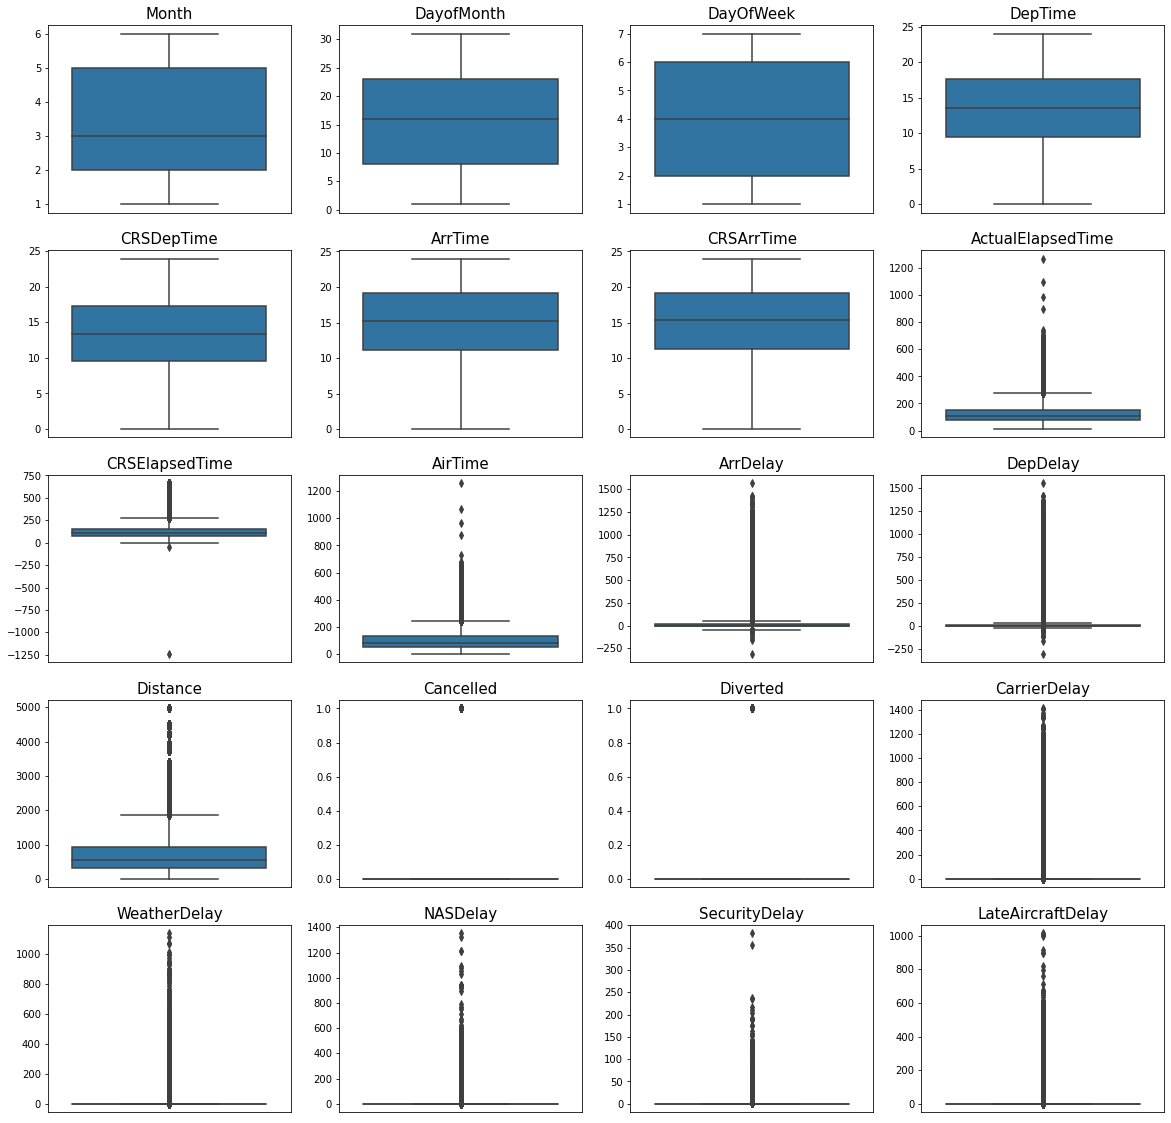

In [37]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
axes = axes.flatten()
for i, column in enumerate(columns_for_visualisation):
    sns.boxplot(data[column], ax=axes[i], orient='v')
    axes[i].set_title(column, fontsize=15)
    axes[i].set_ylabel('')
    axes[i].set_xticks([])
plt.show()

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(10,10))
for c, i in zip(data.columns, range(0,len(data.columns))):
    a = data.boxplot(column=c, ax=axes.flatten()[i])
plt.tight_layout()
plt.show()

#### TO DO: Dodać komentarz dotyczący boxplotów

### HISTOGRAMY

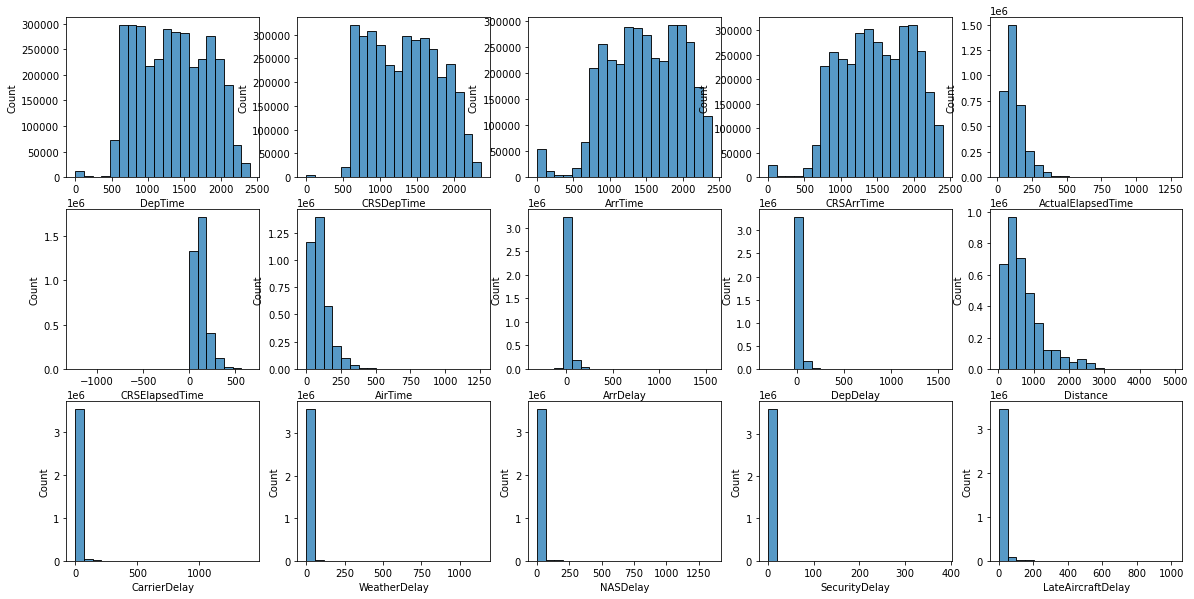

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))
axes = axes.flatten()
for i, column in enumerate(columns_for_visualisation):
    sns.histplot(data[column], ax=axes[i], bins=20)
plt.show()

In [ ]:
fig, axes = plt.subplots(4, 6, figsize=(10,10))
for c, i in zip(data.columns, range(0,24)):
    a = data.hist(column=c, ax=axes.flatten()[i], log= True)
plt.tight_layout()
plt.show()

#### TO DO: Dodać komentarz dotyczący histogramów

### SCATTER PLOT

In [40]:
columns_for_scatter = ['DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime']

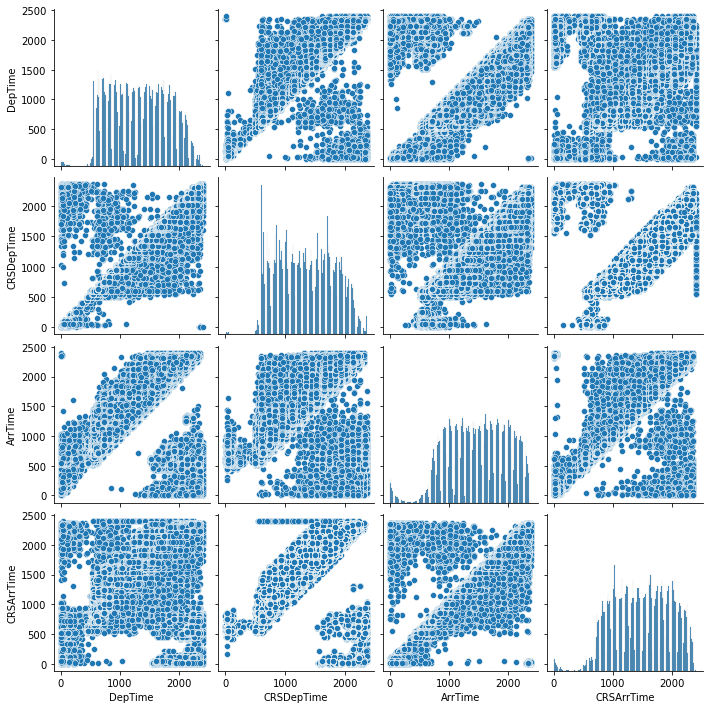

In [42]:
#scatter plot matrix
sns.pairplot(data, vars=columns_for_scatter)

#### TO DO: Dodać komentarz dotyczący scatterplot

## PROBLEMY Z DANYMI - DANE BRAKUJĄCE, NIEPRAWIDŁOWE, ODSTAJĄCE

### SPRAWDZENIE POPRAWNOŚCI TYPÓW DANYCH

In [20]:
import pyarrow as pa

table = pa.Table.from_pandas(data)
print(table.schema)

Year: int64
Month: int64
DayofMonth: int64
DayOfWeek: int64
DepTime: double
CRSDepTime: int64
ArrTime: double
CRSArrTime: int64
FlightNum: int64
ActualElapsedTime: double
CRSElapsedTime: double
AirTime: double
ArrDelay: double
DepDelay: double
Distance: double
TaxiIn: double
TaxiOut: double
Cancelled: double
Diverted: double
CarrierDelay: double
WeatherDelay: double
NASDelay: double
SecurityDelay: double
LateAircraftDelay: double
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 3110


#### TO DO: Dodać komentarz dotyczący danych w złym formacie

### NAPRAWA WIERSZY Z PUSTYMI DANYMI

In [21]:
# Obliczenie ilosci pustych danych
np.sum(data.isna())

Year                     0
Month                    0
DayofMonth               0
DayOfWeek                0
DepTime              91112
CRSDepTime               0
ArrTime              99155
CRSArrTime               0
FlightNum                0
ActualElapsedTime    99155
CRSElapsedTime         390
AirTime              99155
ArrDelay             99155
DepDelay             91112
Distance                 1
TaxiIn                   1
TaxiOut                  1
Cancelled                1
Diverted                 1
CarrierDelay             1
WeatherDelay             1
NASDelay                 1
SecurityDelay            1
LateAircraftDelay        1
dtype: int64

In [22]:
sizeBeforeDeleteNull= data.count()
dataWithoutNull = data.dropna()
sizeAfterDeleteNull =  dataWithoutNull.count()
print("Usunieto: ", sizeBeforeDeleteNull - sizeAfterDeleteNull)

print("Percent od reduced rows: ", 100*sum(sizeBeforeDeleteNull - sizeAfterDeleteNull)/sum(sizeBeforeDeleteNull))

Usunieto:  Year                 99156
Month                99156
DayofMonth           99156
DayOfWeek            99156
DepTime               8044
CRSDepTime           99156
ArrTime                  1
CRSArrTime           99156
FlightNum            99156
ActualElapsedTime        1
CRSElapsedTime       98766
AirTime                  1
ArrDelay                 1
DepDelay              8044
Distance             99155
TaxiIn               99155
TaxiOut              99155
Cancelled            99155
Diverted             99155
CarrierDelay         99155
WeatherDelay         99155
NASDelay             99155
SecurityDelay        99155
LateAircraftDelay    99155
dtype: int64
Percent od reduced rows:  2.1018490808621557


In [ ]:
### TO DO: ZMIENIC SPOSÓB RADZENIA SOBIE Z PUSTYMI DANYMI
### TO DO: Dodać komentarz dotyczący danych pustych

### USUWANIE DANYCH ODSTAJĄCYCH

In [23]:
sizeBefore = np.shape(data)[0]
for col in data.columns:
    data = data[np.abs(data[col]-data[col].mean()) <= (3*data[col].std())]
sizeAfter =  np.shape(data)[0]
print("Count of reduced rows: ", sizeBefore - sizeAfter)
print("Percent od reduced rows: ", 100*(sizeBefore - sizeAfter)/sizeBefore)

Count of reduced rows:  847397
Percent od reduced rows:  23.581953980797643


#### TO DO: Dodać komentarz dotyczący danych odstających

# KORELACJE

In [ ]:
# sns.pairplot(data)

In [ ]:
# plt.figure(figsize=(20, 20), dpi=80)
# corrMatrix = data.corr()
# sns.heatmap(corrMatrix, annot=True)
# plt.show()

#### TO DO: Dodać komentarz dotyczący korelacji między danymi, ew dodać pairploty do wybranych danych

In [ ]:
### TO DO: "Normalizacja danych (przedstawić wyniki min-max i standaryzacji). Zastanowić się nad zakresem skalowania danych"


## REDUKCJA WYMIAROWOŚCI

In [ ]:
### TO DO: Genetyczna optymalizacja cech

In [29]:
# Genetyczna optymalizacja cech - NA RAZIE SAMA SELEKCJA NA PODSTAWIE KORELACJI
pandasDF = data.filter(["DayOfWeek", "DayofMonth", "Distance", "DepTime", "Cancelled", "Diverted", "LateAircraftDelay"], axis = 1)

# PRZYGOTOWANIE MODELI REGRESJI

In [30]:
spark = SparkSession.builder.master("local").appName("Project").getOrCreate()
sparkDF=spark.createDataFrame(pandasDF)
sparkDF.printSchema()

root
 |-- DayOfWeek: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Diverted: double (nullable = true)
 |-- LateAircraftDelay: double (nullable = true)



### PODZIAŁ DANYCH
Zeby nieco uproscic model przypisalismy opoznienie do 5 kategorii.

In [ ]:
from pyspark.ml.feature import VectorAssembler
vector = VectorAssembler(inputCols = ['DayOfWeek', 'DayofMonth', 'Distance', 'DepTime', 'Cancelled', 'Diverted'
], outputCol = 'features')
sparkDF = sparkDF.withColumn("LateAircraftDelay", when(sparkDF <30, 1)
                             .when(30 <= sparkDF < 60, 2)
                             .when(60 <= sparkDF < 180, 3)
                             .when(180 <= sparkDF, 4)
                             .otherwise(0))
vectorData = vector.transform(sparkDF).select(['features', 'LateAircraftDelay'])
vectorData.plot.bar(x = 'parameter', y= 'Coefficients')
plt.show()

vectorData.show(5)

KeyboardInterrupt: 

In [26]:
train_df, test_df = sparkDF.randomSplit([0.7, 0.3])
print("train.rows: ", train_df.count())
print("test.rows: ", test_df.count())

In [ ]:
### MIARY SKUTECZNOŚCI
from pyspark.ml.evaluation import RegressionEvaluator

evaluatorRMSE = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
evaluatorR2 = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")


def effectivenessMeasures(model, predictions):
    print("Coefficients: " + str(model.coefficients))
    print("Intercept: " + str(model.intercept))
    print(predictions.show(5))
    rmse = evaluatorRMSE.evaluate(predictions)
    r2 = evaluatorR2.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    print("R2 on test data = %g" % r2)


### LOGISTIC REGRESSION

In [ ]:
from pyspark.ml.regression import LinearRegression

linear_reg = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=20, regParam=0.3, elasticNetParam=0.8)
linear_model = linear_reg.fit(train_df)
linear_predictions = linear_model.transform(test_df)
effectivenessMeasures(linear_model, linear_predictions)

## RANDOM FOREST regressor

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer

rf = RandomForestRegressor(featuresCol = 'features', labelCol='label')

rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)

effectivenessMeasures(rf_model, rf_predictions)

## DECISION TREE REGRESSOR

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='label')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)

effectivenessMeasures(dt_model, dt_predictions)

## K-KROTNA WALIDAJA KRZYŻOWA

In [ ]:
from random import seed
from random import randrange

def cross_validation_split(data, folds):
    dataset = data.copy().to_numpy()
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [ ]:

# TO DO:  PRZETESTOWANIE ZESPOLU KLASYFIKTOROW POJEDYNCZYCH I PORÓWNANIE WYNIKÓW


In [ ]:
### DECISION TREE CLASSIFIER

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
df7 = df6.select(["features", "SoilType"])
(trainingData, testData) = df7.randomSplit([0.7, 0.3])
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="SoilType").fit(trainingData)
pred = dtc.transform(testData)
pred.show()

In [ ]:
# RANDOM FOREST CLASSIFIER

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="SoilType", featuresCol="features", numTrees=10).fit(trainingData)
pred = rf.transform(testData)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType", metricName='accuracy')
acc = evaluator.evaluate(pred)
print("Prediction Accuracy: ", acc)

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType", metricName='f1Measure')
f1 = evaluator.evaluate(pred)
print("F1: ", f1)

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType", metricName='precision')
precision = evaluator.evaluate(pred)
print("Precision: ", precision)

y_pred=pred.select("prediction").collect()
y_orig=pred.select("SoilType").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

In [ ]:
### MUTICLASS CLASSIFICATION EVALUATOR


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType")
acc = evaluator.evaluate(pred)
print("Prediction Accuracy: ", acc)

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType", metricName='f1Measure')
f1 = evaluator.evaluate(pred)
print("F1: ", f1)

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType", metricName='precision')
precision = evaluator.evaluate(pred)
print("Precision: ", precision)

y_pred=pred.select("prediction").collect()
y_orig=pred.select("SoilType").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
df6.toPandas()["SoilType"].hist()

In [ ]:
# TO DO:
## -  wybór odpowiedniej metryki
## -  testy innych metryk
## -  testowanie miar dla walidacji krzyżowej

In [ ]:
# TO DO: optymalizacja parametrow klasyfikatorow

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from random import seed
from random import randrange

extra_tree = ExtraTreeRegressor(random_state=0)
extra_tree_model = ExtraTreesRegressor(n_estimators = 100,
          criterion ='mse', max_features = "auto")
extra_tree_model.fit(x_train, y_train)

feature_importance = extra_tree_model.feature_importances_
plt.bar(x_train.columns, feature_importance)
plt.xticks(rotation=40)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()


In [ ]:
import seaborn as sns
figure(figsize=(8, 6), dpi=80)

corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

plt.bar(data.columns[:11], corrMatrix["cnt"][:11])
plt.xticks(rotation=40)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

In [ ]:
data = read_data()

size_before_opt = np.shape(data)[1] - 1
print("Ilosc wymairów zmiennych zależnych przed optymalizacją: ", size_before_opt)
data.drop('season', inplace=True, axis=1)
data.drop('mnth', inplace=True, axis=1)
data.drop('holiday', inplace=True, axis=1)
data.drop('weathersit', inplace=True, axis=1)
data.drop('temp', inplace=True, axis=1)
data.drop('hum', inplace=True, axis=1)
data.drop('windspeed', inplace=True, axis=1)
size_after_opt = np.shape(data)[1] - 1
print("Ilosc wymairów zmiennych zależnych po optymalizacji: ",size_after_opt)

x_train, x_test, y_train, y_test = splitOfData(data, 0.20)

In [ ]:
# TO DO: wyniki

In [ ]:
from prettytable import PrettyTable

def add_row(table, result, model):
    avg_result = [sum(x) / len(x) for x in zip(*result)]
    table.add_row([model, round(avg_result[0],5), round(avg_result[1],5), round(avg_result[2],5)])

def createSummaryTable(summary_table, results):
    add_row(summary_table, results[0], "Linear Regression")
    add_row(summary_table, results[1], "Polynominal Regression")
    add_row(summary_table, results[2], "Decision Tree Regression")
    add_row(summary_table, results[3], "Random Forrest Regression")
    add_row(summary_table, results[4], "Voting Regressor")
    add_row(summary_table, results[5], "Stacking Regressor")

def createSummary(k_fold = 0, grid_search_optimalization = False):
    summary_table = PrettyTable(['model', 'MSE', 'r2', 'Experience Variance'])
    if (k_fold < 2):
        results = prepare_result(grid_search_optimalization)
        createSummaryTable(summary_table, results)
        print("Summary table for result of regression models:\n", summary_table, "\n\n")
    else:
        results = prepare_result_with_k_fold(k_fold, grid_search_optimalization)
        createSummaryTable(summary_table, results)
        print("Summary table for result of regression models [K_fold: k =",k_fold,"]:\n", summary_table, "\n\n")

In [ ]:
createSummary()
createSummary(k_fold = 2)
createSummary(k_fold = 5)
createSummary(k_fold = 10)